---
title: "Volatility Forecasting"
date: 2024-10-15
author: Yuan Han Lim
theme: minty
highlight-style: atom-one
format: 
  html:
    number-sections: true
    toc: true
    code-fold: true
embed-resources: true
jupyter: python3
  
---


**Part 2: Backtest (Jupyter Notebook & Quarto Report) -- 100 pts**

This backtest will include 10 ETFs in `etf_universe.csv` of your choosing.  Your analysis should include the following:

1. You will determine the length of the backtest based on data availability, but it should be at least five years.  It should go up until the present.                                              
2. You will use Sepp's $R^2$ metric, and another metric of your choosing (or creation). Give a justification for your metric, and why it makes sense.                                                          
3. For each underlying, the garch will probably take a few minutes to run, so I would suggest getting started on this first to make sure you have the data that you need.  Make sure to save your garch forecasts in a CSV, so the grader doesn't have to run code that takes a long time to finish.
4. Your final conclusion will be your choice of forecast methodology if you were making investment decisions based on these forecasts.  Justify your answer with your analysis.
5. Your analysis should include readable prose, and at least 1-2 visualizations.  You will be graded on the neatness and communication quality of your notebook and report.
6. Include all your code in a Jupyter Notebook and Quarto Document report.
   
**Grading Rubric:**
- accuracy of results: 50 pts
- writing/presentation quality: 35 pts
- code commenting: 15 pts

#  Determination of the 10 ETFs and the Backtest period

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import sys
yf.pdr_override()
from pandas_datareader import data as pdr
import sklearn
pd.options.display.max_rows = 10
from sklearn.linear_model import LinearRegression
from arch import arch_model
import seaborn as sns
import matplotlib.pyplot as plt
mdl_reg = LinearRegression(fit_intercept = True)

data = {
    'Ticker': ["SPY", "QQQ", "GLD", "HYG","EWH","EWZ","EWW","TLT","EWU","IWM"],
    'Underlying Index':["SPDR S&P 500 ETF","PowerShares QQQ Trust","SPDR Gold Trust","iShares iBoxx $ High Yield Corporate Bond ETF","iShares MSCI Hong Kong ETF",
                        "iShares MSCI Brazil Capped ETF","iShares MSCI Mexico Capped ETF","iShares 20+ Year Treasury Bond ETF","iShares MSCI United Kingdom ETF","iShares Russell 2000 ETF"]
}

df = pd.DataFrame(data)
df.set_index('Ticker', inplace=True)
df

/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_30419/2414340765.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Underlying Index
Ticker                                               
SPY                                  SPDR S&P 500 ETF
QQQ                             PowerShares QQQ Trust
GLD                                   SPDR Gold Trust
HYG     iShares iBoxx $ High Yield Corporate Bond ETF
EWH                        iShares MSCI Hong Kong ETF
EWZ                    iShares MSCI Brazil Capped ETF
EWW                    iShares MSCI Mexico Capped ETF
TLT                iShares 20+ Year Treasury Bond ETF
EWU                   iShares MSCI United Kingdom ETF
IWM                          iShares Russell 2000 ETF

In [2]:
def close_to_close(r):
    T = r.shape[0]
    r_bar = r.mean()
    vol = np.sqrt((1 / (T - 1)) * ((r - r_bar) ** 2).sum()) * np.sqrt(252)
    return(vol)
def Parkinson(df):
    high = df.high
    low = df.low
    Parkinson = (1/(4*np.log(2)))*np.sum((np.log(high/low))**2) * np.sqrt(252)
    return Parkinson
def Garman_Klass(df):
    open = df.open
    close = df.close
    high = df.high
    low = df.low
    German_Klass = np.sum(1/2*(np.log(high/low))**2 - ((2*np.log(2)-1)*(np.log(close/open))**2))  * np.sqrt(252)
    return German_Klass
def Rogers_Satchell(df):
    open = df.open
    close = df.close
    high = df.high
    low = df.low
    Rogers_Satchell = np.sum((np.log(high/close)*np.log(high/open))+(np.log(low/close)*np.log(low/open)))*np.sqrt(252)
    return Rogers_Satchell
def Yang_Zhang(df):
    T = df.shape[0]
    open = df.open
    close = df.close
    high = df.high
    low = df.low
    over_night = df.overnight
    overnight_bar = df.overnight.mean()
    open_close = df.open_close
    open_close_bar = df.open_close.mean()
    c = 0.34/(1.34+((T+1)/(T-1)))
    Rogers_Satchell = np.sum((np.log(high/close)*np.log(high/open))+(np.log(low/close)*np.log(low/open)))
    sigma_overnight = np.sum((over_night - overnight_bar)**2)
    sigma_open_to_close = np.sum((open_close - open_close_bar)**2)
    Yang_Zhang =(sigma_overnight + c*sigma_open_to_close + (1-c)*Rogers_Satchell) *np.sqrt(252)
    return Yang_Zhang

## Time series of volatility estimates

I observe the trend and its dispersion for the `SPY` using weekly samples from 2014 to 2024.

In [3]:
### Uncomment the for loop to generate csv (It'll take around 20 minutes) 

def forecast_volatility(ticker, start_date='2014-10-01', end_date='2024-10-14'):
    # Fetching data for the provided ticker
    df = yf.download(ticker, start=start_date, end=end_date, progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    df['dly_ret'] = np.log(df['adj_close']).diff()
    df.dropna(inplace = True)
    df.reset_index(drop = True, inplace = True)
    ser_returns = df['dly_ret'] * 100
    ser_returns.index = df['trade_date']
    model = arch_model(ser_returns, vol = 'Garch', p = 1, o = 0, q = 1, dist = 'Normal')
    result = model.fit(update_freq = 5)
    ix_cutoff_start = df.query('trade_date == "2014-10-14"').index[0]
    ix_cutoff_end = df.query('trade_date == "2024-10-11"').index[0]
    forecasts = {}
    for ix in range(ix_cutoff_start, ix_cutoff_end):
        sys.stdout.write('.')
        sys.stdout.flush()
        result = model.fit(first_obs = (ix - ix_cutoff_start), last_obs = ix, disp = 'off')
        temp = result.forecast(horizon = 5, reindex = True).variance
        fcast = temp.iloc[ix - 1]
        forecasts[fcast.name] = fcast

    df_forecast = pd.DataFrame(pd.DataFrame(forecasts).T)
    df_forecast = df_forecast.reset_index().rename(columns = {'index':'trade_date'})
    # writing variance estimates to csv-file
    filename = f'variance_forecast_{ticker}.csv'
    df_forecast.to_csv(filename, index=False)
    print(f'Forecast saved to {filename}')

#tickers = ["IWM"]
#for ticker in tickers:           
#   forecast_volatility(ticker)

In [4]:
# Common function to fetch and process the data
def fetch_and_process_data(ticker):
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns={'date': 'trade_date'}, inplace=True)
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop=True)
    
    weekday = df['trade_date'].dt.weekday
    week_num = [0]
    ix_week = 0
    for ix in range(1, len(weekday)):
        if weekday[ix] < weekday[ix - 1]:
            ix_week += 1
        week_num.append(ix_week)
    
    df.insert(2, 'week_num', week_num)
    
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min': 'week_start', 'max': 'week_end'})
                    .reset_index()
                    .rename(columns={'index': 'week_num'}))
    
    df = df.merge(df_start_end)
    
    return df

# Parkinson's model
def get_parkinson(ticker):
    df = fetch_and_process_data(ticker)
    df_parkinson = (df.groupby('week_num')[['high', 'low']]
                    .apply(Parkinson)
                    .to_frame().reset_index()
                    .rename(columns={0: 'parkinson'}))
    return df_parkinson[['parkinson']][:-1]

# Rogers-Satchell model
def get_rogers(ticker):
    df = fetch_and_process_data(ticker)
    df_rogers = (df.groupby('week_num')[['high', 'low', 'open', 'close']]
                 .apply(Rogers_Satchell)
                 .to_frame().reset_index()
                 .rename(columns={0: 'rogers'}))
    return df_rogers[['rogers']][:-1]

# Garman-Klass model
def get_garman(ticker):
    df = fetch_and_process_data(ticker)
    df_garman = (df.groupby('week_num')[['high', 'low', 'open', 'close']]
                 .apply(Garman_Klass)
                 .to_frame().reset_index()
                 .rename(columns={0: 'garman'}))
    return df_garman[['garman']][:-1]

# Close-to-Close model
def get_close_to_close(ticker):
    df = fetch_and_process_data(ticker)
    close_to_close_values = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                             .agg(lambda x: np.std(x) * np.sqrt(252))
                             .rename(columns={'dly_ret': 'close_to_close'}))
    return close_to_close_values[['close_to_close']][:-1]

# GARCH model
def get_garch(ticker):
    df = fetch_and_process_data(ticker)
    filename = f'variance_forecast_{ticker}.csv'
    df_forecast = pd.read_csv(filename)
    df_forecast['trade_date'] = pd.to_datetime(df_forecast['trade_date'])
    df_forecast['volatility_forecast'] = \
        np.sqrt((df_forecast['h.1'] + df_forecast['h.2'] + df_forecast['h.3'] +
                 df_forecast['h.4'] + df_forecast['h.5']) / 100)
    
    return df.merge(df_forecast, left_on='week_end', right_on='trade_date')['volatility_forecast']

# Yang-Zhang model
def get_yan_zhang(ticker):
    df = fetch_and_process_data(ticker)
    df['overnight'] = np.log(df['open']) - np.log(df['close']).shift(1)
    df['open_close'] = np.log(df['close']) - np.log(df['open'])
    
    df_yan_zhang = (df.groupby('week_num')[['high', 'low', 'open', 'close', 'overnight', 'open_close']]
                    .apply(Yang_Zhang)
                    .to_frame().reset_index()
                    .rename(columns={0: 'yan_zhang'}))
    return df_yan_zhang[['yan_zhang']][:-1]


/Users/yuanhanlim/anaconda3/lib/python3.10/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_30419/3737526323.py:20: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg([min, max])['trade_date']
/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_30419/3737526323.py:20: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg([min, max])['trade_date']
/Users/yuanhanlim/anac

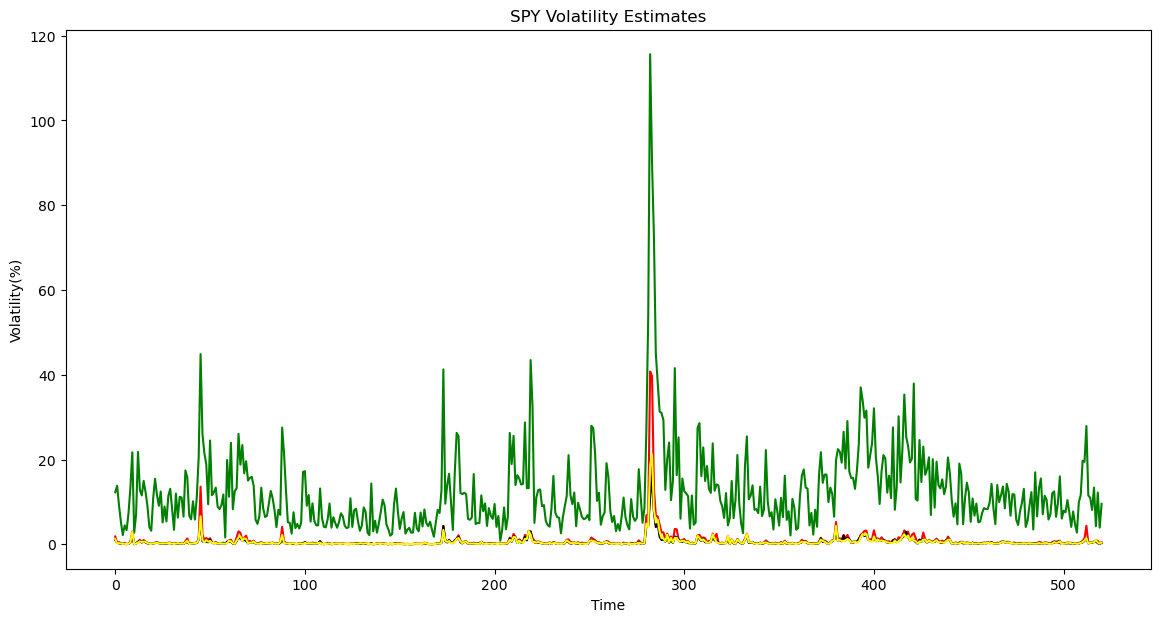

In [5]:
# Plot the forecasted values
ticker = 'SPY'  
#Ploting the volatility for each estimators in %
volatility_forecasts = get_garch(ticker) * 100
yan_zhang = get_yan_zhang(ticker) * 100
close_to_close_plot = get_close_to_close(ticker) * 100
garman_vol = get_garman(ticker) * 100  
parkinson  = get_parkinson(ticker) * 100
rogers = get_rogers(ticker) * 100
plt.figure(figsize=(14,7))
plt.plot(yan_zhang.reset_index(drop=True), label="Yan-Zhang", color="red")  
plt.plot(close_to_close_plot.reset_index(drop=True), label="Close-to-Close", color="green") 
plt.plot(garman_vol.reset_index(drop=True), label="Garman", color="purple") 
plt.plot(parkinson.reset_index(drop=True), label="Parkinson", color="black")
plt.plot(rogers.reset_index(drop=True), label="Rogers-SatChell", color="yellow")  
plt.title('SPY Volatility Estimates')
plt.xlabel('Time')
plt.ylabel('Volatility(%)')

plt.show()

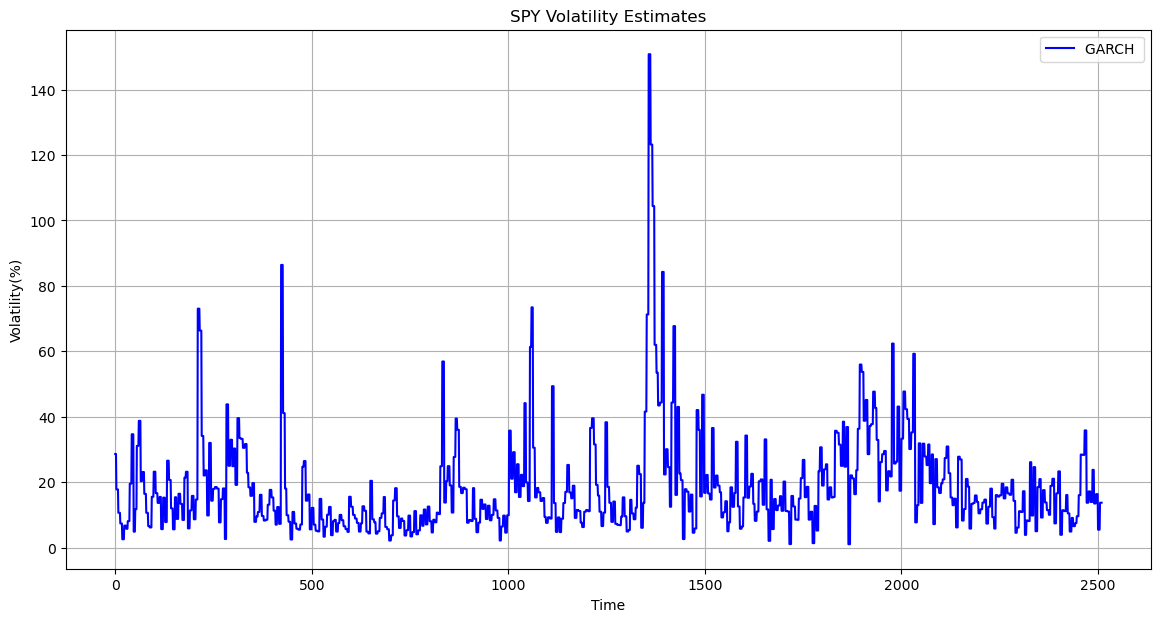

In [6]:
plt.figure(figsize=(14,7))
plt.plot(volatility_forecasts, label="GARCH ", color="blue")
plt.title('SPY Volatility Estimates')
plt.xlabel('Time')
plt.ylabel('Volatility(%)')
plt.legend()
plt.grid(True)
plt.show()

The Close-to-Close, Yang-Zhang, and GARCH models incorporate overnight returns, which typically results in higher volatility estimates. Among these, the GARCH model tends to produce the highest volatility estimates. In contrast, the Garman-Klass, Parkinson, and Rogers-Satchell models focus on intraday returns, which generally leads to lower volatility estimates compared to those that account for overnight price movements.

## Empirical Kernel Density of weekly volatility estimates

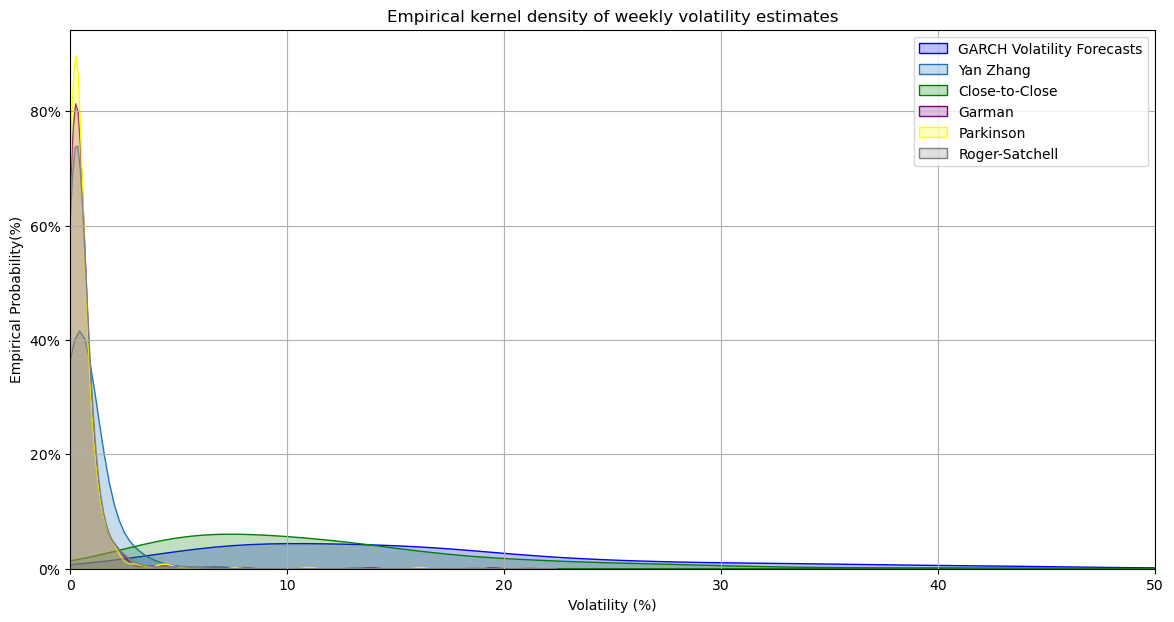

In [7]:
import warnings
warnings.filterwarnings("ignore")
ticker = 'SPY'  
# get the vol estimate and convert to %
volatility_forecasts = get_garch(ticker) * 100
yan_zhang = get_yan_zhang(ticker) * 100
close_to_close_plot_1 = get_close_to_close(ticker) * 100
garman_vol = get_garman(ticker) * 100  
parkinson  = get_parkinson(ticker) * 100
rogers = get_rogers(ticker) * 100
#ploting each estimate
plt.figure(figsize=(14,7))
sns.kdeplot(volatility_forecasts, label="GARCH Volatility Forecasts", color="blue", shade=True, cumulative=False)
sns.kdeplot(yan_zhang, label="Yan Zhang", color="red", shade=True, cumulative=False)
sns.kdeplot(close_to_close_plot_1['close_to_close'], label="Close-to-Close", color="green", shade=True, cumulative=False)
sns.kdeplot(garman_vol['garman'], label="Garman", color="purple", shade=True, cumulative=False)
sns.kdeplot(parkinson['parkinson'], label="Parkinson", color="yellow", shade=True, cumulative=False)
sns.kdeplot(rogers['rogers'], label="Roger-Satchell", color="gray", shade=True, cumulative=False)
plt.title("Empirical kernel density of weekly volatility estimates")
plt.xlabel('Volatility (%)')
plt.ylabel('Empirical Probability(%)')     
plt.legend()
plt.grid(True)
# Format y-axis labels as percentages
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
# Set x-axis range to 0-50%
plt.xlim(0, 50)
plt.show()

According to the volatility analysis (referenced in @fig-volatility-pdf), the Garman-Klass, Parkinson, and Rogers-Satchell models, which do not include overnight returns, tend to produce lower and more tightly clustered volatility estimates. In contrast, the Close-to-Close, Yang-Zhang, and GARCH models incorporate overnight returns, leading to higher volatility estimates with a broader range of variation. Among these, GARCH generally produces the highest volatility estimates compared to Close-to-Close and Yang-Zhang. Interestingly, while Yang-Zhang also factors in overnight returns, its estimates are more concentrated than those of Close-to-Close and GARCH. This is likely because Yang-Zhang includes intraday returns, specifically the open-to-close returns and the Rogers-Satchell volatility component, which balance its volatility estimation.

## Backtesting


For each of the 10 ETFs:

1. Calculate 6 time series of realized volatility using 10 years of data (from 2014-10-14 to 2024-10-11) for the following estimators: Close to Close, Parkinson, Garman-Klass, Rogers-Satchell, Yang-Zhang. 
2. For each estimator, perform a linear regression of the predicted volatility at time t against the realized volatility at time t+1, and  calculate the predictive power ($R^2$) of each of the 6 estimators.
3. Rank the 6 estimators based on their predictive power.
4. Assign scores based on ranking: the estimator in 1st place receives 3 points, 2nd place gets 2 points, and 3rd place receives 1 point.
5. Aggregate the scores for each estimator across all 10 ETFs.

In [ ]:
# ***** the following code is similar to code commenting in part 1. but for this case, we want to generate the dataframe for accumulated test********
def close_to_close_dataframe(ticker):
    # get the data for each ticker
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close) to calculate the daily return
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop=True)
    # adjust the data to weekday number and invert to the number of week for each period
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week += 1
        week_num.append(ix_week)
    np.array(week_num) # the array indicate the number of week so we can track the predicted value
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min':'week_start', 'max':'week_end'})
                    .reset_index()
                    .rename(columns={'index':'week_num'}))
    df = df.merge(df_start_end)# mergine the weeknum, week_start, and week_end into dataframe
    # get the realized vol for regresstion at time t+1
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                   .agg(lambda x: np.std(x) * np.sqrt(252))
                   .rename(columns={'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    # get the predicted vol for close to close at time t
    df_close_to_close = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                         .agg(close_to_close)
                         .rename(columns={'dly_ret':'close_to_close'}))
    df_close_to_close = df_close_to_close[0:-1]
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = df_close_to_close[['close_to_close']]
    y = df_realized['realized_vol']
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, y)
    return {
        "Ticker": ticker,
        "R2_close_to_close": mdl_reg.score(X, y),
        "Intercept_close_to_close": mdl_reg.intercept_,
        "Slope_close_to_close": mdl_reg.coef_[0],
        "Bias_close_to_close": np.mean(df_close_to_close['close_to_close'] - df_realized['realized_vol']),
        "Efficiency_close_to_close": np.std(df_realized['realized_vol']) / np.std(df_close_to_close['close_to_close'])}

def parkinson_dataframe(ticker):
    # get the data for each ticker
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close)
    df['dly_ret'] = np.log(df['close']).diff()
    #same process as close to close to adjust the dataframe according to the number of week for each period
    df = df[1:].reset_index(drop=True)
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week += 1
        week_num.append(ix_week)
    np.array(week_num)
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min':'week_start', 'max':'week_end'})
                    .reset_index()
                    .rename(columns={'index':'week_num'}))
    df = df.merge(df_start_end)
    #get the realized vol
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                   .agg(lambda x: np.std(x) * np.sqrt(252))
                   .rename(columns={'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    #get the predicted vol for parkinson
    df_parkinson = (df.groupby(['week_num'])[['high', 'low']].apply(Parkinson)
                    .to_frame()
                    .reset_index()
                    .rename(columns={0:'parkinson'}))
    df_parkinson = df_parkinson[:-1]
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = df_parkinson['parkinson'].values.reshape(-1,1)
    y = df_realized['realized_vol'].values.reshape(-1,1)
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, y)
    return {
        "Ticker": ticker,
        "R2_parkinson": mdl_reg.score(X, y),
        "Intercept_parkinson": mdl_reg.intercept_[0],
        "Slope_parkinson": mdl_reg.coef_[0][0],
        "Bias_parkinson": np.mean(df_parkinson['parkinson'].values.reshape(-1,1) -  df_realized['realized_vol'].values.reshape(-1,1)),
        "Efficiency_parkinson": np.std(df_realized['realized_vol'].values.reshape(-1,1)) / np.std(df_parkinson['parkinson'].values.reshape(-1,1))}

def garman_dataframe(ticker):
    # get the data for each ticker
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close)
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop=True)
    #same process as close to close to adjust the dataframe according to the number of week for each period
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week += 1
        week_num.append(ix_week)
    np.array(week_num)
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min':'week_start', 'max':'week_end'})
                    .reset_index()
                    .rename(columns={'index':'week_num'}))
    df = df.merge(df_start_end)
    # get the realized vol
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                   .agg(lambda x: np.std(x) * np.sqrt(252))
                   .rename(columns={'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    # get the predicted vol for Garman-Klass
    df_garman = (df.groupby(['week_num'])[['high', 'low','open','close']].apply(Garman_Klass)
                    .to_frame()
                    .reset_index()
                    .rename(columns={0:'garman'}))
    df_garman = df_garman[:-1]
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = df_garman['garman'].values.reshape(-1,1)
    y = df_realized['realized_vol'].values.reshape(-1,1)
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, y)
    return {
        "Ticker": ticker,
        "R2_garman": mdl_reg.score(X, y),
        "Intercept_garman": mdl_reg.intercept_[0],
        "Slope_garman": mdl_reg.coef_[0][0],
        "Bias_garman": np.mean(df_garman['garman'].values.reshape(-1,1) - df_realized['realized_vol'].values.reshape(-1,1)),
        "Efficiency_garman": np.std(df_realized['realized_vol'].values.reshape(-1,1)) / np.std(df_garman['garman'].values.reshape(-1,1))}

def rogers_dataframe(ticker):
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close)
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop=True)
    #same process as close to close to adjust the dataframe according to the number of week for each period
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week += 1
        week_num.append(ix_week)
    np.array(week_num)
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min':'week_start', 'max':'week_end'})
                    .reset_index()
                    .rename(columns={'index':'week_num'}))
    df = df.merge(df_start_end)
    # get the realized vol
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                   .agg(lambda x: np.std(x) * np.sqrt(252))
                   .rename(columns={'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    # get the predicted vol for Rogers-Satchell
    df_rogers = (df.groupby(['week_num'])[['high', 'low','open','close']].apply(Rogers_Satchell)
                    .to_frame()
                    .reset_index()
                    .rename(columns={0:'rogers'}))
    df_rogers = df_rogers[:-1]
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = df_rogers['rogers'].values.reshape(-1,1)
    y = df_realized['realized_vol'].values.reshape(-1,1)
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, y)
    return {
        "Ticker": ticker,
        "R2_rogers": mdl_reg.score(X, y),
        "Intercept_rogers": mdl_reg.intercept_[0],
        "Slope_rogers": mdl_reg.coef_[0][0],
        "Bias_rogers": np.mean(df_rogers['rogers'].values.reshape(-1,1) - df_realized['realized_vol'].values.reshape(-1,1)),
        "Efficiency_rogers": np.std(df_realized['realized_vol'].values.reshape(-1,1)) / np.std(df_rogers['rogers'].values.reshape(-1,1))}

def yan_zhang_dataframe(ticker):
    #get the data for each ticker
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close)
    df['dly_ret'] = np.log(df['close']).diff()
    # overnight (close-to-open)
    df['overnight'] = np.log(df['open']) - np.log(df['close']).shift(1)
    # intraday (open-to-close)
    df['open_close'] = np.log(df['close']) - np.log(df['open'])
    df = df[1:].reset_index(drop=True)
    #same process as close to close to adjust the dataframe according to the number of week for each period
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week += 1
        week_num.append(ix_week)
    np.array(week_num)
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index=False)[['trade_date']]
                    .agg([min, max])['trade_date']
                    .rename(columns={'min':'week_start', 'max':'week_end'})
                    .reset_index()
                    .rename(columns={'index':'week_num'}))
    df = df.merge(df_start_end)
    #get the realized vol 
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index=False)[['dly_ret']]
                   .agg(lambda x: np.std(x) * np.sqrt(252))
                   .rename(columns={'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    # get the predicted vol for Yang-Zhang
    df_yan_zhang = (df.groupby(['week_num'])[['high', 'low','open','close','overnight','open_close']].apply(Yang_Zhang)
                    .to_frame()
                    .reset_index()
                    .rename(columns={0:'yan_zhang'}))
    df_yan_zhang = df_yan_zhang[:-1]
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = df_yan_zhang['yan_zhang'].values.reshape(-1,1)
    y = df_realized['realized_vol'].values.reshape(-1,1)
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, y)
    return {
        "Ticker": ticker,
        "R2_yan_zhang": mdl_reg.score(X, y),
        "Intercept_yan_zhang": mdl_reg.intercept_[0],
        "Slope_yan_zhang": mdl_reg.coef_[0][0],
        "Bias_yan_zhang": np.mean(df_yan_zhang['yan_zhang'].values.reshape(-1,1) - df_realized['realized_vol'].values.reshape(-1,1)),
        "Efficiency_yan_zhang": np.std(df_realized['realized_vol'].values.reshape(-1,1)) / np.std(df_yan_zhang['yan_zhang'].values.reshape(-1,1))}

def garch_dataframe(ticker):
    # get the 10 year worth of data 
    df = yf.download(ticker, start='2014-10-14', end='2024-10-11', progress=False).reset_index()
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns = {'date':'trade_date'}, inplace = True)
    # daily (close-to-close)
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop = True)
    #same process as close to close to adjust the dataframe according to the number of week for each period
    weekday = df['trade_date'].dt.weekday
    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week = ix_week + 1
        week_num.append(ix_week)
    np.array(week_num)
    df.insert(2, 'week_num', week_num)
    df_start_end = (df.groupby(['week_num'], as_index = False)[['trade_date']].agg([min, max])['trade_date']
        .rename(columns = {'min':'week_start', 'max':'week_end'})
        .reset_index()
        .rename(columns = {'index':'week_num'}))
    df = df.merge(df_start_end)
    # get the realized vol
    df_realized = (df.groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']].agg(lambda x: np.std(x) * np.sqrt(252))
        .rename(columns = {'dly_ret':'realized_vol'}))
    df_realized = df_realized[1:]
    # Load the forecast CSV for the given ticker
    filename = f'variance_forecast_{ticker}.csv'
    df_forecast = pd.read_csv(filename)
    df_forecast['trade_date'] = pd.to_datetime(df_forecast['trade_date'])
    #calculate the vol for each day
    df_forecast['volatility_forecast'] = np.sqrt((df_forecast['h.1'] + df_forecast['h.2'] + df_forecast['h.3'] + df_forecast['h.4'] + df_forecast['h.5']) / 100)
    df_start_end.merge(df_forecast[['trade_date', 'volatility_forecast']], left_on = 'week_end', right_on = 'trade_date')
    #get the predicted vol for GARCH
    volatility_forecasts = df_start_end.merge(df_forecast, left_on = 'week_end', right_on = 'trade_date')['volatility_forecast']
    # put the realized vol and predicted vol into linear regression and report the metric regarding sepp's result
    X = volatility_forecasts.values.reshape(-1, 1)
    Y = df_realized['realized_vol'].values.reshape(-1,1)
    mdl_reg = LinearRegression()
    mdl_reg.fit(X, Y)
    return {
        "Ticker": ticker,
        "R2_garch": mdl_reg.score(X, Y),
        "Intercept_garch": mdl_reg.intercept_[0],
        "Slope_garch": mdl_reg.coef_[0][0],
        "Bias_garch": np.mean(volatility_forecasts.values.reshape(-1,1) - df_realized['realized_vol'].values.reshape(-1,1)),
        "Efficiency_garch": np.std(df_realized['realized_vol'].values.reshape(-1,1)) / np.std(volatility_forecasts[:-1].values.reshape(-1,1))}

# Constucting the Summary Table according to sepp's result
# defining the tickers
tickers = ["SPY", "QQQ", "GLD", "HYG","EWH","EWZ","EWW","TLT","EWU","IWM"]
# put it in each def to construct the metric
results_c = [close_to_close_dataframe(ticker) for ticker in tickers]
close_to_close_df = pd.DataFrame(results_c).set_index('Ticker')
results_p = [parkinson_dataframe(ticker) for ticker in tickers]
parkinson_df = pd.DataFrame(results_p).set_index('Ticker')
results_g = [garman_dataframe(ticker) for ticker in tickers]
garman_df = pd.DataFrame(results_g).set_index('Ticker')
results_r = [rogers_dataframe(ticker) for ticker in tickers]
rogers_df = pd.DataFrame(results_r).set_index('Ticker')
results_y = [yan_zhang_dataframe(ticker) for ticker in tickers]
yan_zhang_df = pd.DataFrame(results_y).set_index('Ticker')
results_g = [garch_dataframe(ticker) for ticker in tickers]
garch_df = pd.DataFrame(results_g).set_index('Ticker')
#combining each estimator's metric into one datafram
combined_df = pd.concat([close_to_close_df,parkinson_df,garman_df,rogers_df,yan_zhang_df, garch_df], axis=1)

# Define the fuction to pass in the combined dataframe to Rank the R^2 and compute the mean and median of R2, Bias, and Efficeincy
def compute_scores_and_statistics(df):
    # Extract the R2 columns.
    r2_cols = [col for col in df.columns if col.startswith('R2_')]
    r2_df = df[r2_cols]
    # Rank and assign points to the R2 values.
    points_mapping = {1: 3, 2: 2, 3: 1}
    ranks = r2_df.rank(axis=1, ascending=False).astype(int)
    points = ranks.replace(points_mapping)
    points[points > 3] = 0
    # Accumulate the scores for each estimator.
    accumulated_scores = points.sum(axis=0)
    # Compute the statistics for each estimator.
    estimators = ['yan_zhang', 'close_to_close', 'garch','parkinson','garman','rogers']
    results = {}
    for estimator in estimators:
        R2_col = f"R2_{estimator}"
        Bias_col = f"Bias_{estimator}"
        Efficiency_col = f"Efficiency_{estimator}"
        if all(column in df.columns for column in [R2_col, Bias_col, Efficiency_col]):
            results[estimator] = [
                accumulated_scores[R2_col],
                df[R2_col].mean(),
                df[R2_col].median(),
                df[Bias_col].mean(),
                df[Bias_col].median(),
                df[Efficiency_col].mean(),
                df[Efficiency_col].median()]
    # Produce the final result.
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=[
        'R2 Score', 'Mean of R2', 'Median of R2', 'Mean of Bias', 
        'Median of Bias', 'Mean of Efficiency', 'Median of Efficiency']).sort_index()
    return result_df.rename(index={
        'yan_zhang': 'Yan-Zhang',
        'close_to_close': 'Close to Close',
        'garch': 'Garch',
        'parkinson': 'Parkinson',
        'garman': 'Garman-Klass',
        'rogers':'Rogers-Satchell'})
# pass in our combined dataframe into the def function to get the sepp's aggregate test's result
compute_scores_and_statistics(combined_df)

After reviewing the performance metrics of the six volatility models (Close-to-Close, GARCH, Garman-Klass, Parkinson, Rogers-Satchell, and Yang-Zhang), the Yang-Zhang model stands out as the best choice for making investment decisions based on volatility forecasts. Here’s why:

1. R² Score:
The Yang-Zhang model has a mean R² of 0.2917 and a median R² of 0.3127, which are among the highest in the group.
While the Parkinson model slightly edges it out in terms of R² (0.2966 mean, 0.3064 median), the difference is small, and R² alone is not the only factor to consider.
2. Bias:
The mean bias of Yang-Zhang (-0.1364) is the lowest (least negative), indicating that its predictions are the closest to being unbiased when compared to the actual realized volatility. This is a crucial factor because lower bias ensures that predictions are not systematically over- or under-estimating the volatility, leading to better decision-making consistency.
Other models like Garman-Klass, Parkinson, and Rogers-Satchell show significantly larger negative biases, suggesting they tend to underestimate volatility more.
3. Efficiency:
The mean efficiency of Yang-Zhang (4.5702) is not as high as some of the other models like Parkinson (12.1056) or Garman-Klass (11.1966). However, extreme efficiency values in those models indicate potential overfitting or an overreaction to noise, which could lead to unreliable volatility forecasts.
Yang-Zhang strikes a good balance by having a more moderate efficiency, which implies that it has a reasonable ability to track actual volatility without overfitting or being too sensitive to extreme market movements.
4. Comprehensive Approach:
The Yang-Zhang model is more robust because it integrates multiple volatility components (overnight returns, open-close, high-low range), capturing the broader dynamics of price movements. This gives it an edge in scenarios where overnight gaps or intraday volatility spikes matter, making it particularly suited for trading strategies sensitive to such market conditions.


Comparison to Other Models:

- Close-to-Close: This is a simpler model, but its R² is lower (0.2819), and the efficiency (0.8930) suggests it’s too simplistic to handle complex market behaviors. It may not perform well under volatile or non-trending markets.
- GARCH: While GARCH is often used for time-varying volatility, its mean R² of 0.2577 and higher bias (0.0728) make it less reliable for short-term decisions compared to Yang-Zhang.
- Parkinson/Garman-Klass/Rogers-Satchell: These models have very high efficiency, but their significant negative bias implies systematic underestimation of volatility, which could lead to under-hedging or risk management issues.

Conclusion:
The Yang-Zhang model provides the most balanced combination of high R², low bias, and reasonable efficiency. Its ability to capture various aspects of volatility (both intraday and overnight) makes it a well-rounded and reliable choice for making investment decisions based on volatility forecasts. Therefore, I would use the Yang-Zhang model as my primary forecasting methodology.